In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
# song_id = 0
# dataset = 'model/keypoint_classifier/keypoint.csv'
model_path = 'model/system/model4'
dataset = model_path +'/keypoint.csv'
model_save_path = model_path+ '/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 4

# Key point 選擇

In [4]:
keypoint_4 = [8, 12, 16 ,20]
keypoint_16 = [i for i in range(5,21)]

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
len(X_dataset)

1885

In [7]:
# test_arr = []

# for data in X_dataset:
#     lst = []
#     for i in keypoint_16:
#         lst.append(data[i*1+i])
#         lst.append(data[i*1+i+1])
#     test_arr.append(lst)
    
# X_dataset = np.array(test_arr)


In [8]:
# len(X_dataset[0])

In [9]:
# X_dataset[0]

In [10]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [11]:
unique, counts = np.unique(y_dataset, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 722]
 [  1 669]
 [  3 494]]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [13]:
key_point_numbers = 21

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((key_point_numbers * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [14]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 914
Trainable params: 914
Non-trainable params: 0
_________________________________________________________________


In [15]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [16]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [17]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.7134 - accuracy: 0.1328
Epoch 00001: saving model to model/system/model4\keypoint_classifier16.hdf5
12/12 [==============================] - 0s 41ms/step - loss: 1.6051 - accuracy: 0.1975 - val_loss: 1.3691 - val_accuracy: 0.3814
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.5681 - accuracy: 0.2500
Epoch 00002: saving model to model/system/model4\keypoint_classifier16.hdf5
12/12 [==============================] - 0s 6ms/step - loss: 1.4620 - accuracy: 0.2718 - val_loss: 1.3083 - val_accuracy: 0.3941
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.3914 - accuracy: 0.3125
Epoch 00003: saving model to model/system/model4\keypoint_classifier16.hdf5
12/12 [==============================] - 0s 6ms/step - loss: 1.3683 - accuracy: 0.3291 - val_loss: 1.2977 - val_accuracy: 0.4343
Epoch 4/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.3241 - accuracy: 0.3828


In [18]:
# Evaluate Accuracy
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 748us/step - loss: 0.8379 - accuracy: 0.7669


In [19]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [20]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [21]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.max(np.squeeze(predict_result)))
print(np.argmax(np.squeeze(predict_result)))

[0.1792 0.3798 0.0002 0.4409]
0.44089183
3


# 混同行列

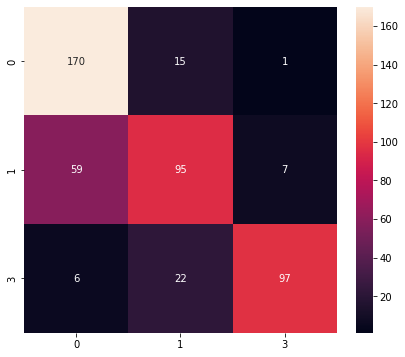

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       186
           1       0.72      0.59      0.65       161
           3       0.92      0.78      0.84       125

    accuracy                           0.77       472
   macro avg       0.79      0.76      0.77       472
weighted avg       0.78      0.77      0.76       472



In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [23]:
# 推論専用のモデルとして保存
model.save(model_save_path,include_optimizer=False)

In [24]:
# モデルを変換(量子化)
tflite_save_path = model_path + '/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Johnny\AppData\Local\Temp\tmpa3zhm3yq\assets


5456

# 推論テスト

In [25]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [26]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [27]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [28]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


#### print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))